## Trying to get self-supervised learning of angles working

Let's go back to basics, ignore the probabilistic stuff and just try to get a NN to learn the angles of MNIST digits. 

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "selfsupervised.ipynb"
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

from typing import Union

from ml_collections import config_dict
import jax.random as random
import jax.numpy as jnp

jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

from absl import logging

from src.utils.training import setup_model, get_dataset_splits, train_loop
import src.utils.input as input_utils
from src.models.common import ResNet18, ResNetTiny
from src.transformations import transform_image


# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

/var/home/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-22 23:17:29.772351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/var/home/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
logging.set_verbosity(logging.INFO)

In [3]:
rng = random.PRNGKey(0)
train_data_rng, val_data_rng, init_rng, state_rng = random.split(rng, 4)

In [4]:
ANGLE = 0

dataset_config = config_dict.ConfigDict()
dataset_config.batch_size = 256
dataset_config.dataset = "MNIST"
dataset_config.shuffle_buffer_size = 50_000
dataset_config.repeat_after_batching = True  # NOTE: ordering of PP, shuffle, and repeat is important!
dataset_config.train_split = f"train[10000:]"
dataset_config.pp_train = f'value_range(-1, 1)|keep(["image", "label"])'
dataset_config.val_split = f"train[:10000]"
dataset_config.pp_eval = f'value_range(-1, 1)|keep(["image", "label"])'


In [5]:
# train_ds, val_ds, _ = get_dataset_splits(dataset_config, data_rng, dataset_config.batch_size, dataset_config.batch_size)

import jax
import jax.numpy as jnp
import tensorflow_datasets as tfds

from clu import deterministic_data
from clu import preprocess_spec

from src.utils.preprocess import all_ops

In [6]:
dataset_builder = tfds.builder('mnist')
dataset_builder.download_and_prepare()

local_batch_size  = dataset_config.batch_size // jax.device_count()

train_ds = deterministic_data.create_dataset(
    dataset_builder,
    split=tfds.split_for_jax_process(dataset_config.train_split),
    # This RNG key will be used to derive all randomness in shuffling, data
    # preprocessing etc.
    rng=train_data_rng,
    shuffle_buffer_size=dataset_config.shuffle_buffer_size,
    # Depending on TPU/other runtime, local device count will be 8/1.
    batch_dims=[jax.local_device_count(), local_batch_size],
    repeat_after_batching=False,
    preprocess_fn=preprocess_spec.parse(
        spec=dataset_config.pp_train,
        available_ops=all_ops(),
    ),
    shuffle="loaded",
    )


num_val_examples = dataset_builder.info.splits[dataset_config.val_split].num_examples
# Compute how many batches we need to contain the entire val set.
pad_up_to_batches = int(jnp.ceil(num_val_examples / dataset_config.batch_size))

val_ds = deterministic_data.create_dataset(
    dataset_builder,
    split=tfds.split_for_jax_process(dataset_config.val_split),
    rng=val_data_rng,
    batch_dims=[jax.local_device_count(), local_batch_size],
    num_epochs=1,
    preprocess_fn=preprocess_spec.parse(
        spec=dataset_config.pp_eval,
        available_ops=all_ops(),
    ),
    # Pad with masked examples instead of dropping incomplete final batch.
    pad_up_to_batches=pad_up_to_batches,
    shuffle=False)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Featur

In [7]:
num_val_examples

10000

In [8]:
pad_up_to_batches

40

In [9]:
dataset_config.batch_size * pad_up_to_batches - num_val_examples

240

In [10]:
batch = next(iter(train_ds))
batch.keys()

dict_keys(['image', 'label'])

In [11]:
batch['image'].shape

TensorShape([1, 256, 28, 28, 1])

In [12]:
it = deterministic_data.start_input_pipeline(val_ds)

counter = 0
for i, batch in enumerate(it):
    mask = batch['mask']
    counter += mask.sum()

print(i, mask.sum())
print(counter)

39 16
10000


In [13]:
from flax.training import train_state

import ciclo
import optax
import distrax

import jax
from jax import lax
import flax
import flax.linen as nn

from clu import parameter_overview

from typing import Any

from functools import partial

PRNGKey = Any

In [14]:
class MyModel(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):

        h = ResNet18(lowres=True, num_classes=10, num_filters=64)(x, train=train)
        # h = nn.Dense(10)(x.flatten())

        return h

model = MyModel()

variables = model.init(init_rng, jnp.empty((28, 28, 1)), train=False)

In [15]:
parameter_overview.log_parameter_overview(variables)

INFO:absl:
+------------------------------------------------+------------------+-----------+-----------+--------+
| Name                                           | Shape            | Size      | Mean      | Std    |
+------------------------------------------------+------------------+-----------+-----------+--------+
| params/ResNet_0/BasicBlock_0/Conv_0/kernel     | (3, 3, 64, 64)   | 36,864    | 3.08e-05  | 0.0415 |
| params/ResNet_0/BasicBlock_0/Conv_1/kernel     | (3, 3, 64, 64)   | 36,864    | -5.56e-05 | 0.0416 |
| params/ResNet_0/BasicBlock_0/LayerNorm_0/bias  | (64,)            | 64        | 0.0       | 0.0    |
| params/ResNet_0/BasicBlock_0/LayerNorm_0/scale | (64,)            | 64        | 1.0       | 0.0    |
| params/ResNet_0/BasicBlock_0/LayerNorm_1/bias  | (64,)            | 64        | 0.0       | 0.0    |
| params/ResNet_0/BasicBlock_0/LayerNorm_1/scale | (64,)            | 64        | 0.0       | 0.0    |
| params/ResNet_0/BasicBlock_1/Conv_0/kernel     | (3, 3, 64, 

In [16]:
TOTAL_STEPS = 100
LR = 3e-3
WD = 1e-3

In [17]:
from clu import metrics

@flax.struct.dataclass  # <-- required for JAX transformations
class Metrics(metrics.Collection):
    loss : metrics.Average.from_output('loss')
    acc : metrics.Accuracy

    def update(self, **kwargs) -> "Metrics":
        updates = self.single_from_model_output(**kwargs)
        return self.merge(updates)

class TrainState(train_state.TrainState):
    metrics: Metrics
    rng: PRNGKey

state = TrainState.create(
    apply_fn=model.apply,
    params=variables["params"],
    tx=optax.adamw(LR),
    metrics=Metrics.empty(),
    rng=state_rng
)

In [18]:
def loss_fn(x, y, params, state, step_rng, train):
    rng_local = random.fold_in(step_rng, lax.axis_index("batch"))
    rng_dropout, _ = random.split(rng_local)

    logits = state.apply_fn(
        {"params": params}, x, train, rngs={"dropout": rng_dropout}
    )

    loss = optax.softmax_cross_entropy_with_integer_labels(logits, y)

    return loss, logits


@jax.jit
def train_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    labels = batch["label"][0]

    def batch_loss_fn(params):
        losses, logits = jax.vmap(loss_fn, in_axes=(0, 0, None, None, None, None), axis_name="batch")(
            batch["image"][0], labels, params, state, step_rng, True
        )

        avg_loss = losses.mean(axis=0)

        return avg_loss, (losses, logits)

    (_, (losses, logits)), grads = jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = state.metrics.update(
        loss=losses, logits=logits, labels=labels,
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())

    return logs, state.replace(metrics=metrics)


@jax.jit
def eval_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    labels = batch["label"][0]
    masks = batch["mask"][0]

    def batch_loss_fn(params):
        losses, logits = jax.vmap(loss_fn, in_axes=(0, 0, None, None, None, None), axis_name="batch")(
            batch["image"][0], labels, params, state, step_rng, False
        )

        avg_loss = (losses * masks).sum(axis=0) / masks.sum(axis=0)

        return avg_loss, (losses, logits)

    _, (losses, logits) = batch_loss_fn(state.params)

    metrics = state.metrics.update(
        loss=losses, logits=logits, labels=labels, mask=masks
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())

    return logs, state.replace(metrics=metrics)

In [19]:
def reset_metrics(state):
    return state.replace(metrics=state.metrics.empty())

# state, history, _ = ciclo.train_loop(
#     state,
#     deterministic_data.start_input_pipeline(train_ds),
#     {
#         ciclo.on_train_step: [
#             train_step
#         ],
#         ciclo.on_reset_step: reset_metrics,
#         ciclo.on_test_step: eval_step,
#     },
#     test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
#     epoch_duration=10, #TOTAL_STEPS // 100,
#     callbacks=[
#         ciclo.keras_bar(total=TOTAL_STEPS),
#     ],
#     stop=TOTAL_STEPS + 1,
# )

get_test_ds = lambda: input_utils.start_input_pipeline(val_ds)


state, history, _ = ciclo.loop(
    state,
    input_utils.start_input_pipeline(train_ds),
    {
        ciclo.every(1): [train_step],
        ciclo.every(10): [
            reset_metrics,
            ciclo.callbacks.inner_loop(
                "valid",
                lambda state: ciclo.loop(
                    state,
                    get_test_ds(),
                    tasks={ciclo.every(1): eval_step},
                    # on_start=[reset_metrics]
                )
            ),
        ],
        ciclo.every(1): [ciclo.keras_bar(total=TOTAL_STEPS)]
    },
    stop=TOTAL_STEPS + 1,
)

100/100 [==============================] - 22s 222ms/step - acc: 0.7395 - loss: 0.8224 - acc_valid: 0.7017 - loss_valid: 0.8979 3:57 - acc: 0.1211 - loss: 3.0255 - acc_valid: 0.0984 - loss_valid: 3.82 - ETA: 3:09 - acc: 0.1258 - loss: 2.9282 - acc_valid: 0.0984 - loss_valid: 3.82 - ETA: 2:37 - acc: 0.1178 - loss: 2.8707 - acc_valid: 0.0984 - loss_valid: 3.82 - ETA: 2:14 - acc: 0.1127 - loss: 2.8163 - acc_valid: 0.0984 - loss_valid: 3.82 - ETA: 1:56 - acc: 0.1147 - loss: 2.7493 - acc_valid: 0.0984 - loss_valid: 3.82 - ETA: 1:43 - acc: 0.1181 - loss: 2.6952 - acc_valid: 0.0984 - loss_valid:  - ETA: 1:08 - acc: 0.1367 - loss: 2.3167 - acc_valid: 0.1425 - loss_valid: 2 - ETA: 55s - acc: 0.1808 - loss: 2.2705 - acc_valid: 0.1425 - loss_valid: 2.322 - ETA: 51s - acc: 0.1841 - loss: 2.2648 - acc_valid: 0.1425 - loss_valid: 2.322 - ETA: 48s - acc: 0.1875 - loss: 2.2561 - acc_valid: 0.1425 - loss_valid: 2 - ETA: 35s - acc: 0.2363 - loss: 2.1570 - acc_valid: 0.1965 - loss_valid: - ETA: 26s - acc

In [20]:
for k, v in history[-1]["stateful_metrics"].items():
    print(k, v.item())

acc 0.739453136920929
acc_valid 0.7017000317573547
loss 0.8223535418510437
loss_valid 0.8979257941246033


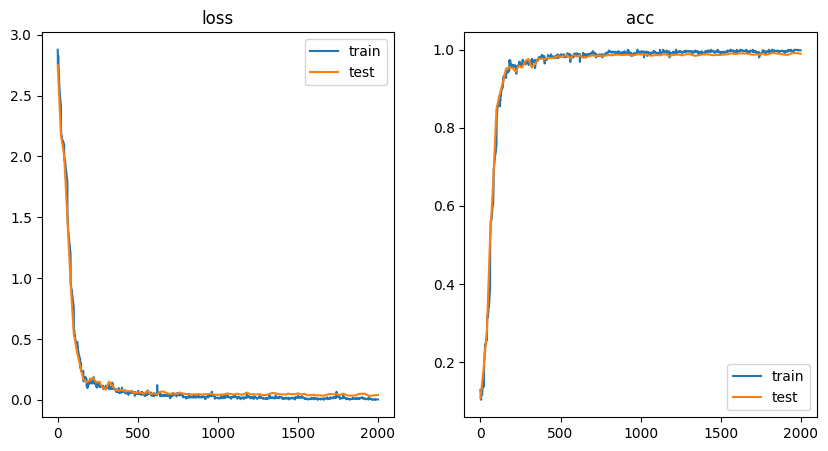

In [ ]:
# plot the training history
steps, loss, acc = history.collect(
    "steps", "loss", "acc",
)
steps_test, loss_test, acc_test = history.collect(
    "steps", "loss_test", "acc_test",
)

n_plots = 2
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

axs[0].plot(steps, loss, label="train")
axs[0].plot(steps_test, loss_test, label="test")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, acc, label="train")
axs[1].plot(steps_test, acc_test, label="test")
axs[1].legend()
axs[1].set_title("acc")

plt.show()

100, shuffle loaded, cache False, repeat before batch, LR = 3e-3, WD = 1e-3, ResNet18, XLA GPU deterministic:

acc 0.739453136920929
acc_test 0.7017000317573547
loss 0.8223535418510437
loss_test 0.8979257941246033

100, shuffle preprocessed, cache batched, repeat after batch, LR = 3e-3, WD = 1e-3, ResNet18, XLA GPU deterministic:

acc 0.739453136920929
acc_test 0.7017000317573547
loss 0.8223535418510437
loss_test 0.8979257941246033
2023-08-22 22:53:48.998376: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854]

100, shuffle loaded, cache batched, repeat after batch, LR = 3e-3, WD = 1e-3, ResNet18, XLA GPU deterministic:

acc 0.739453136920929
acc_test 0.7017000317573547
loss 0.8223535418510437
loss_test 0.8979257941246033
2023-08-22 22:50:28.633170: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854]

100, no test but reset, shuffle loaded, cache loaded, repeat after batch, LR = 3e-3, WD = 1e-3, ResNet18, XLA GPU deterministic:

acc 0.739453136920929
loss 0.8223535418510437

acc 0.739453136920929
loss 0.8223535418510437

100, shuffle loaded, cache loaded, repeat after batch, LR = 3e-3, WD = 1e-3, ResNet18, XLA GPU deterministic:

acc 0.739453136920929
acc_test 0.7017000317573547
loss 0.8223535418510437
loss_test 0.8979257941246033

acc 0.739453136920929
acc_test 0.7017000317573547
loss 0.8223535418510437
loss_test 0.8979257941246033

100, no test, shuffle loaded, no cache, repeat after batch, LR = 3e-3, WD = 1e-3, ResNet18, XLA GPU deterministic:

acc 0.7578125
loss 0.796474039554596

acc 0.7578125
loss 0.796474039554596

acc 0.7578125
loss 0.796474039554596

100, no test, no shuffle, no cache, repeat before batch, LR = 3e-3, WD = 1e-3, ResNet18, XLA GPU deterministic:

acc 0.59375
loss 1.0938681364059448
2023-08-22 15:53:51.090986: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854]

acc 0.59375
loss 1.0938681364059448
2023-08-22 15:52:32.035346: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854]

100, no test, no shuffle, no cache, repeat before batch, stashed changes, LR = 3e-3, WD = 1e-3, ResNetTiny(32), XLA GPU deterministic:

acc 0.8515625
loss 0.5279662013053894
2023-08-22 15:48:34.022133: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854]

100/100 [==============================] - 26s 264ms/step - acc: 0.8516 - loss: 0.5280
acc 0.8515625
loss 0.5279662013053894
2023-08-22 16:01:04.630000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854]

100/100 [==============================] - 27s 266ms/step - acc: 0.8516 - loss: 0.5280
acc 0.8515625
loss 0.5279662013053894
2023-08-22 15:46:21.440154: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854]

100, no test, no shuffle, no cache, repeat before batch, stashed changes, LR = 3e-3, WD = 1e-3, ResNetTiny(32):

acc 0.86328125
loss 0.5056402087211609
2023-08-22 15:36:58.872000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

acc 0.71875
loss 0.8408331871032715
2023-08-22 15:35:35.893158: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854]

acc 0.84765625
loss 0.5119426250457764
2023-08-22 15:33:45.485033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854]

100, no test, no shuffle, no cache, repeat before batch, stashed changes, LR = 3e-3, WD = 1e-3, ResNetTiny(64):

acc 0.7890625
loss 0.7098046541213989
2023-08-22 15:30:04.634683: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

acc 0.6171875
loss 0.9862861633300781
2023-08-22 15:25:54.110794: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

100, no test, no shuffle, no cache, repeat before batch, stashed changes, LR = 3e-3, WD = 1e-3, ResNetTiny(1):

acc 0.11328125
loss 2.3040499687194824
2023-08-22 15:23:03.269878: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

acc 0.11328125
loss 2.3040499687194824
2023-08-22 15:21:42.323859: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

acc 0.11328125
loss 2.3040499687194824
2023-08-22 15:20:24.963137: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

acc 0.85546875
loss 0.48007380962371826
2023-08-22 15:16:48.547867: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

acc 0.85546875
loss 0.48007380962371826
2023-08-22 15:15:49.310411: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

acc 0.85546875
loss 0.48007380962371826
2023-08-22 15:14:58.706456: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 


100, no test, no shuffle, no cache, repeat before batch, stashed changes, LR = 0, WD = 1e-3:

100/100 [==============================] - 33s 328ms/step - acc: 0.0703 - loss: 2.4778
acc 0.0703125
loss 2.4777677059173584
2023-08-22 15:09:56.611940: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

100, no test, no shuffle, no cache, repeat before batch, stashed changes, LR = 0, WD = 0:

100/100 [==============================] - 33s 328ms/step - acc: 0.0703 - loss: 2.4778
acc 0.0703125
loss 2.4777677059173584
2023-08-22 15:08:16.597586: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

100/100 [==============================] - 33s 328ms/step - acc: 0.0703 - loss: 2.4778
acc 0.0703125
loss 2.4777677059173584
2023-08-22 15:06:27.521083: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

100/100 [==============================] - 33s 329ms/step - acc: 0.0703 - loss: 2.4778
acc 0.0703125
loss 2.4777677059173584
2023-08-22 15:04:55.853410: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 


100, no test, no shuffle, no cache, repeat before batch, stashed changes:

acc 0.82421875
loss 0.6642556190490723
2023-08-22 15:02:37.467105: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

100/100 [==============================] - 33s 332ms/step - acc: 0.8125 - loss: 0.6655
acc 0.8125
loss 0.66551673412323
2023-08-22 14:59:02.852975: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

100, no test, no shuffle, no cache, repeat before batch:

acc 0.78125
loss 0.7724179625511169
2023-08-22 14:42:40.867300: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

acc 0.79296875
loss 0.7085044384002686
2023-08-22 14:41:04.306002: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

acc 0.78515625
loss 0.7331324815750122
2023-08-22 14:34:00.288036: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

acc 0.703125
loss 0.9183658361434937
2023-08-22 14:32:39.733722: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

100, no test, no shuffle, no cache:

acc 0.70703125
loss 0.8108610510826111
2023-08-22 14:28:48.702609: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

acc 0.68359375
loss 0.9597969651222229
2023-08-22 14:26:51.165551: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 

100, no test, no shuffle:

acc 0.8046875
loss 0.7466309070587158
2023-08-22 14:24:37.055666: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] 
2023-08-22 14:24:37.063837: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

acc 0.57421875
loss 1.1315155029296875
2023-08-22 14:22:49.489761: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-22 14:22:49.495913: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

acc 1.0
loss 0.022883404046297073

100, no test:

acc 0.765625
loss 0.7324202060699463

acc 0.69921875
loss 0.9034873247146606

acc 0.7265625
loss 0.8131300806999207

100:

acc 0.6875
acc_test 0.7927000522613525
loss 0.8675796985626221
loss_test 0.7182118892669678

acc 0.7578125
acc_test 0.7807000279426575
loss 0.7292100191116333
loss_test 0.7477455139160156

acc 0.6953125
acc_test 0.7159000635147095
loss 0.8982169032096863
loss_test 0.839320182800293

10:

acc 0.140625
acc_test 0.14150001108646393
loss 2.3124794960021973
loss_test 2.32320237159729

acc 0.140625
acc_test 0.14150001108646393
loss 2.3124804496765137
loss_test 2.323202610015869

4: 

acc 0.125
acc_test 0.14110000431537628
loss 2.5635015964508057
loss_test 2.5505518913269043

acc 0.125
acc_test 0.14110000431537628
loss 2.5634963512420654
loss_test 2.550546884536743

acc 0.125
acc_test 0.14110000431537628
loss 2.563502788543701
loss_test 2.5505526065826416

2: 

acc 0.1640625
acc_test 0.10220000147819519
loss 3.105966567993164
loss_test 2.537973642349243

acc 0.1640625
acc_test 0.10220000147819519
loss 3.105966567993164
loss_test 2.537973642349243

acc 0.1640625
acc_test 0.10220000147819519
loss 3.105966806411743
loss_test 2.537973642349243

1: 

acc 0.09375
acc_test 0.12790000438690186
loss 3.933764934539795
loss_test 3.0991764068603516

acc 0.09375
acc_test 0.12790000438690186
loss 3.933764934539795
loss_test 3.0991766452789307

acc 0.09375
acc_test 0.12790000438690186
loss 3.933764934539795
loss_test 3.0991766452789307



1/1 [==============================] - 15s 15s/step - acc: 0.0938 - loss: 3.9338 - acc_test: 0.1279 - loss_test: 3.0992
1/1 [==============================] - 16s 16s/step - acc: 0.0938 - loss: 3.9338 - acc_test: 0.1279 - loss_test: 3.0992
1/1 [==============================] - 16s 16s/step - acc: 0.0938 - loss: 3.9338 - acc_test: 0.1279 - loss_test: 3.0992

2/2 [==============================] - 16s 8s/step - acc: 0.1641 - loss: 3.1060 - acc_test: 0.1022 - loss_test: 2.5380
2/2 [==============================] - 16s 8s/step - acc: 0.1641 - loss: 3.1060 - acc_test: 0.1022 - loss_test: 2.5380
2/2 [==============================] - 16s 8s/step - acc: 0.1641 - loss: 3.1060 - acc_test: 0.1022 - loss_test: 2.5380

4/4 [==============================] - 17s 4s/step - acc: 0.1152 - loss: 2.5313 - acc_test: 0.1411 - loss_test: 2.5505
4/4 [==============================] - 17s 4s/step - acc: 0.1152 - loss: 2.5313 - acc_test: 0.1411 - loss_test: 2.5505
4/4 [==============================] - 17s 4s/step - acc: 0.1152 - loss: 2.5313 - acc_test: 0.1411 - loss_test: 2.5505

10/10 [==============================] - 16s 2s/step - acc: 0.1207 - loss: 2.6569 - acc_test: 0.1415 - loss_test: 2.3232
10/10 [==============================] - 16s 2s/step - acc: 0.1207 - loss: 2.6569 - acc_test: 0.1416 - loss_test: 2.3232
10/10 [==============================] - 16s 2s/step - acc: 0.1207 - loss: 2.6569 - acc_test: 0.1415 - loss_test: 2.3232

20/20 [==============================] - 18s 884ms/step - acc: 0.1895 - loss: 2.2525 - acc_test: 0.1939 - loss_test: 2.1950
20/20 [==============================] - 18s 882ms/step - acc: 0.1891 - loss: 2.2524 - acc_test: 0.1942 - loss_test: 2.1949

50/50 [==============================] - 22s 449ms/step - acc: 0.3516 - loss: 1.8561 - acc_test: 0.3850 - loss_test: 1.7622
50/50 [==============================] - 22s 440ms/step - acc: 0.3547 - loss: 1.8555 - acc_test: 0.3856 - loss_test: 1.7666

100/100 [==============================] - 30s 300ms/step - acc: 0.7484 - loss: 0.7884 - acc_test: 0.7954 - loss_test: 0.6723
100/100 [==============================] - 30s 298ms/step - acc: 0.7516 - loss: 0.7908 - acc_test: 0.7762 - loss_test: 0.7332